<a href="https://colab.research.google.com/github/emamanni/AnalisiDeiDati24-25/blob/main/12_RegressioneLineare_PuLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisi di regressione: determinare il vettore $\mathbf{w}$ che minimizza una misura di errore risolvendo un problema di ottimizzazione lineare

In questo notebook si determinerà il valore ottimale del vettore di pesi $\mathbf{w}$  per definire un modello di regressione lineare, minimizzando diverse misure di errore.

Per ogni misura di errore, il valore ottimale $\mathbf{w}^*$ sarà ottenuto risolvendo un modello di programmazione lineare.

L'analisi sarà condotta su un dataset, denominato sales_vs_ads.csv, contenente i dati su spesa in spot televisivi (attributo x1), spesa in spot sui giornali (attributo x2) e dati relativi alle vendite (attributo y). x1 e x2 saranno le variabili esplicative e y sarà la variabile target.

In [1]:
# "Montiamo" il drive per poter accedere al file
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

import os

# Percorso alla directory che contiene i file da utilizzare
# Percorso da modificare in base alla propria macchina
folder_path = '/content/drive/MyDrive/Colab Notebooks/Notebook Corso Analisi dei Dati/FileDiSupporto'

Mounted at /content/drive


In [2]:
file_path_csv = os.path.join(folder_path, 'sales_vs_ads.csv')

import pandas as pd

# leggiamo il dataset
data = pd.read_csv(file_path_csv, header=0)

In [3]:
# estraiamo le colonne delle variabili esplicative, della variabile target e il numero di osservazioni
X = data[['x1', 'x2']].values
y = data['y'].values
m = len(y)
print("Variabili esplicative:\n", X, "\n")
print("Variabile target:\n", y, "\n")
print("Numero di osservazioni:", m)

Variabili esplicative:
 [[ 2.96  4.45]
 [ 5.25  0.64]
 [ 0.9   5.01]
 [ 6.77  5.07]
 [ 5.72  3.27]
 [ 5.69  6.01]
 [11.76  6.45]
 [ 6.03  6.81]
 [ 6.02  7.19]
 [ 6.06 13.26]
 [18.46  7.94]
 [ 6.52 21.38]
 [ 6.58  8.64]
 [ 8.51 11.73]
 [ 6.89  9.33]
 [ 6.63  9.71]
 [ 6.9   8.3 ]
 [ 6.69 10.4 ]
 [ 7.38 10.79]
 [ 7.5  10.93]] 

Variabile target:
 [ 371.88  484.55   85.47  613.85  531.31  628.3  1167.89  626.87  724.01
  817.08 1325.71 1064.86  802.38  934.75  774.84  920.35  835.48  755.61
  814.83  826.21] 

Numero di osservazioni: 20


## Minimizzazione dell'errore assoluto medio

Per minimizzare l'errore assoluto medio, occorre risolvere il seguente problema di ottimizzazione non vincolata:

$$
\min_{\mathbf{w}} \frac{1}{m} \sum_{i=1}^{m} |y_i - \mathbf{w}^\top \mathbf{x}_i|.
$$

Dato che il problema sopra riportato, a causa della presenza del valore assoluto, è non lineare, lo linearizziamo introducendo un vettore di $m$ variabili ausiliarie, $\mathbf{k} = [k_1, \dots, k_m]$, che rappresentano le deviazioni assolute: $k_i = |y_i - \mathbf{w}^T \mathbf{x}_i|$. Con questa modifica, il problema precedente è equivalente alla risoluzione del seguente problema di Programmazione Lineare:

$$
\min_{\mathbf{w}, \mathbf{k}} \frac{1}{m} \sum_{i=1}^{m} k_i
$$
<center>s.v.</center>
$$
k_i \geq y_i - \mathbf{w}^\top \mathbf{x}_i, \quad \forall i=1,\dots, m
$$
$$
k_i \geq \mathbf{w}^\top \mathbf{x}_i - y_i, \quad \forall i=1,\dots, m
$$

In [4]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 70.0 MB/s eta 0:00:00


In [5]:
from pulp import *

prob = LpProblem("Minimizzazione_MAE", LpMinimize)

# Variabili
w0 = LpVariable("w0")
w1 = LpVariable("w1")
w2 = LpVariable("w2")
k = LpVariable.dicts("k", range(m), lowBound=0)

# Funzione obiettivo
obj = 1/m * lpSum(k[i] for i in range(m))
prob += obj

# Vincoli
for i in range(m):
  prob += k[i] >= y[i] - w0 - w1*X[i, 0] - w2*X[i, 1]
  prob += k[i] >= -y[i] + w0 + w1*X[i, 0] + w2*X[i, 1]


# Soluzione del problema
prob.solve(PULP_CBC_CMD(msg=0))

# Status della soluzione
print("Status:", LpStatus[prob.status])

if prob.status == LpStatusOptimal:
  # Stampa dei risultati
  print("Soluzione ottima:")
  print("w0 =", value(w0))
  print("w1 =", value(w1))
  print("w2 =", value(w2))
  print("Funzione obiettivo =", value(obj))
else:
  print("Soluzione ottima non trovata")

Status: Optimal
Soluzione ottima:
w0 = 79.167927
w1 = 63.814799
w2 = 26.642637
Funzione obiettivo = 55.90170312


In [6]:
def stampa_errori(X, y, w0, w1, w2):

  errore_medio = 0
  for i in range(m):
    x1_i, x2_i = X[i, 0], X[i, 1]
    y_real = y[i]
    y_hat = w0 + w1 * x1_i + w2 * x2_i
    errore = y_real - y_hat
    errore_medio += errore
    print("Osservazione ", i, "- valore osservato  ", y_real, "- valore previsto ",
          y_hat, "- errore ", errore)
  print("Errore medio:", errore_medio/m)

In [7]:
stampa_errori(X, y, value(w0) , value(w1) , value(w2) )

Osservazione  0 - valore osservato   371.88 - valore previsto  386.61946669 - errore  -14.739466690000029
Osservazione  1 - valore osservato   484.55 - valore previsto  431.2469094300001 - errore  53.30309056999994
Osservazione  2 - valore osservato   85.47 - valore previsto  270.08085746999996 - errore  -184.61085746999996
Osservazione  3 - valore osservato   613.85 - valore previsto  646.27228582 - errore  -32.422285819999956
Osservazione  4 - valore osservato   531.31 - valore previsto  531.31000027 - errore  -2.700001004996011e-07
Osservazione  5 - valore osservato   628.3 - valore previsto  602.39638168 - errore  25.903618319999964
Osservazione  6 - valore osservato   1167.89 - valore previsto  1001.47497189 - errore  166.4150281100001
Osservazione  7 - valore osservato   626.87 - valore previsto  645.40752294 - errore  -18.53752294000003
Osservazione  8 - valore osservato   724.01 - valore previsto  654.8935770100001 - errore  69.11642298999993
Osservazione  9 - valore osservato 

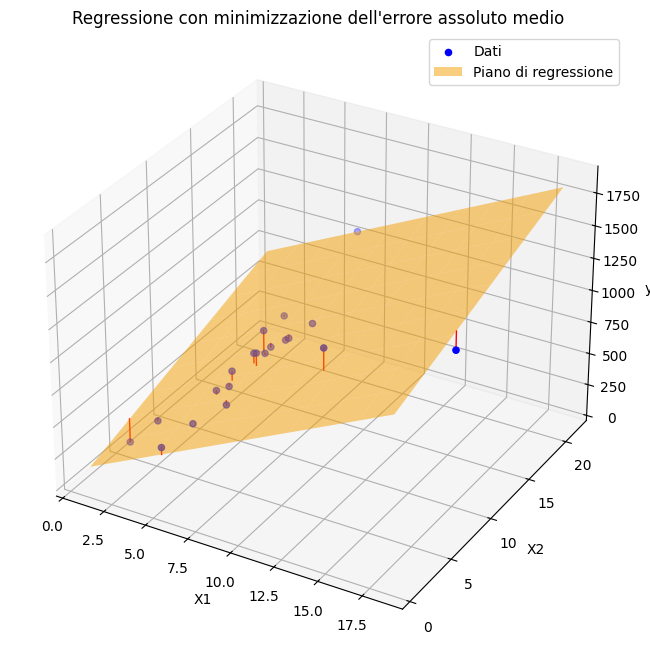

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Recuperiamo i valori ottimali per w
w0_opt = value(w0)
w1_opt = value(w1)
w2_opt = value(w2)

# Rappresentiamo graficamente la soluzione
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')

# Rappresentiamo graficamente i dati osservati
ax.scatter(X[:, 0], X[:, 1], y, color='blue', label='Dati')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('y')
ax.set_title("Regressione con minimizzazione dell'errore assoluto medio")

# Rappresentiamo graficamente il piano di regressione
X1, X2 = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 10),
                     np.linspace(X[:, 1].min(), X[:, 1].max(), 10))
y_pred = w0_opt + w1_opt * X1 + w2_opt * X2
ax.plot_surface(X1, X2, y_pred, color='orange', alpha=0.5, label='Piano di regressione')

# Tracciamo le linee verticali che misurano la distanza tra ogni punto e il piano di regressione
for i in range(m):
    x1_i, x2_i = X[i, 0], X[i, 1]
    y_real = y[i]
    y_hat = w0_opt + w1_opt * x1_i + w2_opt * x2_i  # Valore previsto

    # Linee verticali
    ax.plot([x1_i, x1_i], [x2_i, x2_i], [y_real, y_hat], color='red', linewidth=1)

plt.legend()
plt.show()

## Minimizzazione dell'errore assoluto massimo

Per minimizzare l'errore assoluto massimo, occorre risolvere il seguente problema di ottimizzazione non vincolata:

$$
\min_{\mathbf{w}} \max_{i} \left| y_i - \mathbf{w}^\top \mathbf{x}_i \right|.
$$

Dato che il problema sopra riportato è non lineare, lo linearizziamo introducendo una variabile ausiliaria $t$ che rappresenta il massimo tra gli errori assoluti, ovvero: $|y_i - \mathbf{w}^T \mathbf{x}_i| \leq t$, $\,\forall i=,\dots,m$. Con questa modifica, il problema precedente è equivalente alla risoluzione del seguente problema di Programmazione Lineare:

$$
\min_{t, \mathbf{w}} \; t
$$
<center>s.v.</center>
$$
y_i - \mathbf{w}^\top \mathbf{x}_i \leq t, \quad \forall i=1,\dots, m
$$
$$
y_i - \mathbf{w}^\top \mathbf{x}_i  \geq -t, \quad \forall i=1,\dots, m
$$

In [9]:
prob = LpProblem("Minimizzazione_MAD", LpMinimize)

# Variabili
w0 = LpVariable("w0")
w1 = LpVariable("w1")
w2 = LpVariable("w2")
t = LpVariable("t")

# Funzione obiettivo
obj = t
prob += obj

# Vincoli
for i in range(m):
  prob += y[i] - w0 - w1 * X[i, 0] - w2 * X[i, 1] <= t
  prob += y[i] - w0 - w1 * X[i, 0] - w2 * X[i, 1] >= -t


# Soluzione del problema
prob.solve(PULP_CBC_CMD(msg=0))

# Status della soluzione
print("Status:", LpStatus[prob.status])

if prob.status == LpStatusOptimal:
  # Stampa dei risultati
  print("Soluzione ottima:")
  print("w0 =", value(w0))
  print("w1 =", value(w1))
  print("w2 =", value(w2))
  print("Funzione obiettivo =", value(obj))
else:
  print("Soluzione ottima non trovata")

Status: Optimal
Soluzione ottima:
w0 = 49.258608
w1 = 65.97545
w2 = 27.887748
Funzione obiettivo = 162.88413


In [10]:
stampa_errori(X, y, value(w0), value(w1), value(w2))

Osservazione  0 - valore osservato   371.88 - valore previsto  368.6464186 - errore  3.2335813999999914
Osservazione  1 - valore osservato   484.55 - valore previsto  413.47787922 - errore  71.07212078000003
Osservazione  2 - valore osservato   85.47 - valore previsto  248.35413047999998 - errore  -162.88413047999998
Osservazione  3 - valore osservato   613.85 - valore previsto  637.30328686 - errore  -23.453286859999935
Osservazione  4 - valore osservato   531.31 - valore previsto  517.8311179599999 - errore  13.47888204000003
Osservazione  5 - valore osservato   628.3 - valore previsto  592.26428398 - errore  36.035716019999995
Osservazione  6 - valore osservato   1167.89 - valore previsto  1005.0058746 - errore  162.88412540000013
Osservazione  7 - valore osservato   626.87 - valore previsto  637.0061353799999 - errore  -10.136135379999928
Osservazione  8 - valore osservato   724.01 - valore previsto  646.94372512 - errore  77.06627488000004
Osservazione  9 - valore osservato   817.

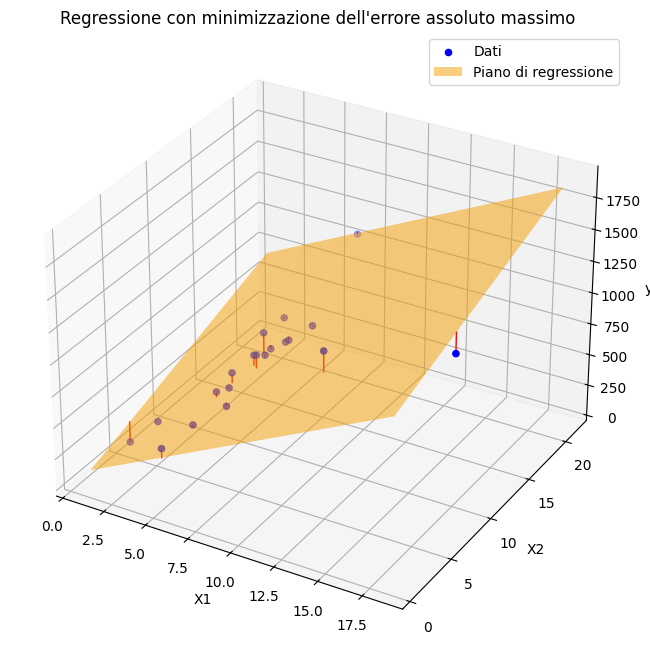

In [11]:
# Recuperiamo i valori ottimali per w
w0_opt = value(w0)
w1_opt = value(w1)
w2_opt = value(w2)

# Rappresentiamo graficamente la soluzione
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')

# Rappresentiamo graficamente i dati osservati
ax.scatter(X[:, 0], X[:, 1], y, color='blue', label='Dati')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('y')
ax.set_title("Regressione con minimizzazione dell'errore assoluto massimo")

# Rappresentiamo graficamente il piano di regressione
X1, X2 = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 10),
                     np.linspace(X[:, 1].min(), X[:, 1].max(), 10))
y_pred = w0_opt + w1_opt * X1 + w2_opt * X2
ax.plot_surface(X1, X2, y_pred, color='orange', alpha=0.5, label='Piano di regressione')

# Tracciamo le linee verticali che misurano la distanza tra ogni punto e il piano di regressione
for i in range(m):
    x1_i, x2_i = X[i, 0], X[i, 1]
    y_real = y[i]
    y_hat = w0_opt + w1_opt * x1_i + w2_opt * x2_i  # Valore previsto

    # Linee verticali
    ax.plot([x1_i, x1_i], [x2_i, x2_i], [y_real, y_hat], color='red', linewidth=1)

plt.legend()
plt.show()

## Minimizzazione dell'errore percentuale assoluto medio

Per minimizzare l'errore percentuale assoluto medio, occorre risolvere il seguente problema di ottimizzazione non vincolata:

$$
\min_{\mathbf{w}} \frac{1}{m}\sum_{i=1}^{m} \left|\frac{y_i - \mathbf{w}^\top \mathbf{x}_i}{y_i}\right|.
$$

Dato che il problema sopra riportato, a causa della presenza del valore assoluto, è non lineare, lo linearizziamo introducendo un vettore di $m$ variabili ausiliarie, $\mathbf{k} = [k_1, \dots, k_m]$, che rappresentano le deviazioni percentuali: $k_i = |(y_i - \mathbf{w}^T \mathbf{x}_i)/y_i|$. Con questa modifica, il problema precedente è equivalente alla risoluzione del seguente problema di Programmazione Lineare:

$$
\min_{\mathbf{w}, \mathbf{k}} \frac{1}{m} \sum_{i=1}^{m} k_i
$$
<center>s.v.</center>
$$
k_i \geq (y_i - \mathbf{w}^\top \mathbf{x}_i)/y_i, \quad \forall i=1,\dots, m
$$
$$
k_i \geq (\mathbf{w}^\top \mathbf{x}_i - y_i)/y_i, \quad \forall i=1,\dots, m
$$

In [12]:
prob = LpProblem("Minimizzazione_MAPD", LpMinimize)

# Variabili
w0 = LpVariable("w0")
w1 = LpVariable("w1")
w2 = LpVariable("w2")
k = LpVariable.dicts("k", range(m), lowBound=0)

# Funzione obiettivo
obj = 1/m * lpSum(k[i] for i in range(m))
prob += obj

# Vincoli
for i in range(m):
  prob += k[i] >= (y[i] - w0 - w1 * X[i, 0] - w2 * X[i, 1])/y[i]
  prob += k[i] >= (-y[i] + w0 + w1 * X[i, 0] + w2 * X[i, 1])/y[i]


# Soluzione del problema
prob.solve(PULP_CBC_CMD(msg=False))

# Status della soluzione
print("Status:", LpStatus[prob.status])

if prob.status == LpStatusOptimal:
  # Stampa dei risultati
  print("Soluzione ottima:")
  print("w0 =", value(w0))
  print("w1 =", value(w1))
  print("w2 =", value(w2))
  print("Funzione obiettivo =", value(obj))
else:
  print("Soluzione ottima non trovata")

Status: Optimal
Soluzione ottima:
w0 = -109.13426
w1 = 100.03305
w2 = 20.873157
Funzione obiettivo = 0.08965937210000002


In [13]:
stampa_errori(X, y, value(w0), value(w1), value(w2))

Osservazione  0 - valore osservato   371.88 - valore previsto  279.84911665000004 - errore  92.03088334999995
Osservazione  1 - valore osservato   484.55 - valore previsto  429.39807298000005 - errore  55.15192701999996
Osservazione  2 - valore osservato   85.47 - valore previsto  85.47000157 - errore  -1.5699999948992627e-06
Osservazione  3 - valore osservato   613.85 - valore previsto  673.9163944899999 - errore  -60.06639448999988
Osservazione  4 - valore osservato   531.31 - valore previsto  531.31000939 - errore  -9.39000005928392e-06
Osservazione  5 - valore osservato   628.3 - valore previsto  585.50146807 - errore  42.79853192999997
Osservazione  6 - valore osservato   1167.89 - valore previsto  1201.88627065 - errore  -33.996270649999815
Osservazione  7 - valore osservato   626.87 - valore previsto  636.2112306700001 - errore  -9.341230670000073
Osservazione  8 - valore osservato   724.01 - valore previsto  643.14269983 - errore  80.86730017000002
Osservazione  9 - valore osse

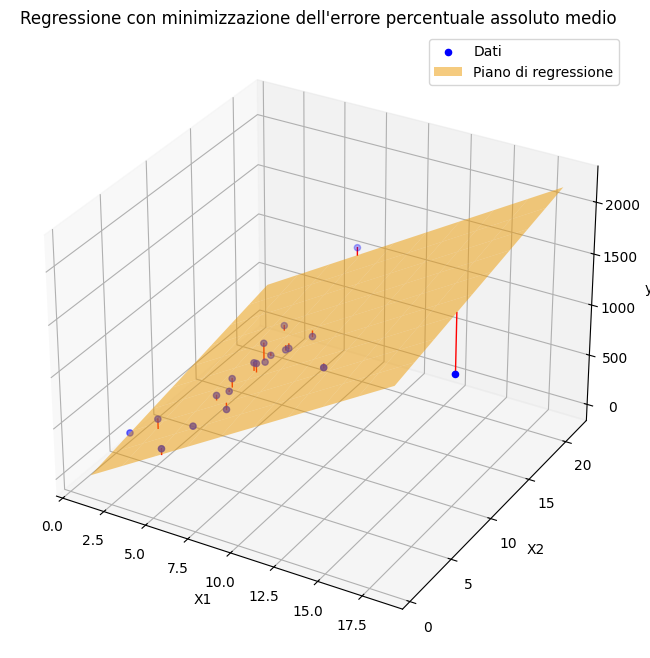

In [14]:
# Recuperiamo i valori ottimali per w
w0_opt = value(w0)
w1_opt = value(w1)
w2_opt = value(w2)

# Rappresentiamo graficamente la soluzione
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')

# Rappresentiamo graficamente i dati osservati
ax.scatter(X[:, 0], X[:, 1], y, color='blue', label='Dati')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('y')
ax.set_title("Regressione con minimizzazione dell'errore percentuale assoluto medio")

# Rappresentiamo graficamente il piano di regressione
X1, X2 = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 10),
                     np.linspace(X[:, 1].min(), X[:, 1].max(), 10))
y_pred = w0_opt + w1_opt * X1 + w2_opt * X2
ax.plot_surface(X1, X2, y_pred, color='orange', alpha=0.5, label='Piano di regressione')

# Tracciamo le linee verticali che misurano la distanza tra ogni punto e il piano di regressione
for i in range(m):
    x1_i, x2_i = X[i, 0], X[i, 1]
    y_real = y[i]
    y_hat = w0_opt + w1_opt * x1_i + w2_opt * x2_i  # Valore previsto

    # Linee verticali
    ax.plot([x1_i, x1_i], [x2_i, x2_i], [y_real, y_hat], color='red', linewidth=1)

plt.legend()
plt.show()